## HOUSE DATA PRICE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm

from sklearn import linear_model, datasets
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, lasso_path, LassoCV

## Chargement des données

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

Paramètres de visualisation pour jupyter

In [3]:
plt.style.use('fivethirtyeight')
pd.options.display.max_columns = 100

## Exploration des données

### Concatenation du dataset pour faciliter le traitement

In [4]:
# enregistrer l'index et 
train_id = train['Id']
test_id = test['Id']

# suppression de l'Id
train.drop(columns ='Id', axis=1, inplace=True)
test.drop(columns ='Id', axis=1, inplace=True)

# sauvegarde du nombre de ligne du train et du test
n_train = train.shape[0]
n_test = test.shape[0]

# mettre le SalePrice le target dans une variable a part
target = train.SalePrice

# suppression de la colonne SalePrice
train.drop(['SalePrice'], axis=1, inplace=True)

#concatenation des data train et test
df_inter = pd.concat((train, test)).reset_index(drop=True)

## Gestion des données manquantes
Visualisation des données manquantes

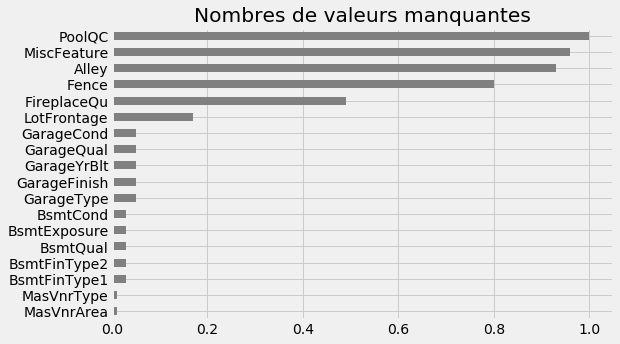

In [5]:
# total_na = round((df_inter.isna().sum().sort_values())/df_inter.shape[0], 2)

# col_miss_values = (total_na[total_na > 0]).index

# total_na[col_miss_values].plot(kind='barh',color='grey',figsize=(8,5),title="Nombres de valeurs manquantes")

On décide de supprimer les colonnes contenant plus de 15% de valeurs manquantes

In [6]:
# cols_low_na = total_na[total_na < 0.15]
# df_inter = df_inter[cols_low_na.index]

In [7]:
#round((df_inter.isna().sum().sort_values(ascending=False))/df_inter.shape[0], 2)

## Gestion des valeurs manquantes
- Que faire du GarageYrBlt ?
- Bsmt => Vérifier qu'il  n'y a pas de basement

### Question 1
Les variables restantes sont-elles corrélées à notre prédiction ? -> Visualisation boxplot pour les qualitatives et scatterplot pour les quantitatives ( --> matrice de corrélation )<br>
### Question 2
Est-ce que des variables nous apporte la même information ? -> Visualisation plot de corrélation ( --> matrice de corrélation )

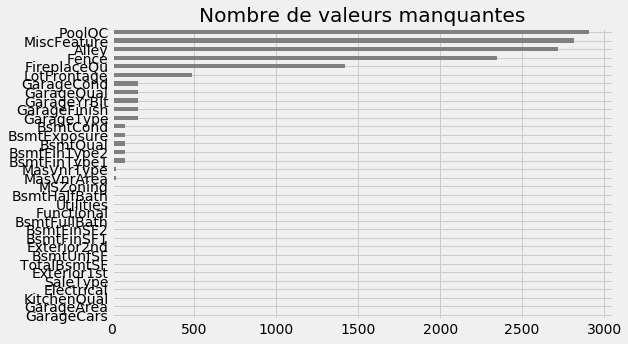

In [5]:
# total_na = df_inter.isna().sum().sort_values()
# total_na[total_na > 0].plot(kind='barh',color='grey',figsize=(8,5),title="Nombre de valeurs manquantes")

In [5]:
# Dans les colonnes à plus de 20% de NA, ont décide de remplacer les np.nan, par des NA string, ce qui pourrais nous 
# permettre de créer une nouvelle classe, s'il y a un eventuelle, on decide donc de les garder au lieu de les supprimer

cols_replace_na_cat = ["GarageType","GarageFinish","GarageQual","GarageCond",'BsmtQual','BsmtCond',
                       'BsmtExposure','BsmtFinType1','BsmtFinType2','MasVnrType']

for i in cols_replace_na_cat:
    df_inter[i].fillna('N/A', inplace=True)

In [6]:
# Nous decidons de remplacer les NA par des 0, plustôt que par la moyenne ou la mediane pour éviter de biaiser les 
# données. on peut peut pas utiliser la moyenne à cause des outliers et en utilisant la médiane on risque d'attriber
# des valeurs à des caractéristiques de maison qui n'existe pas.

cols_replace_na_num =['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath', 'BsmtHalfBath',
                      'GarageYrBlt','GarageArea','GarageCars','MasVnrArea']

for i in cols_replace_na_num:
    df_inter[i].fillna(0, inplace=True)
    


In [7]:
# Les variables listée ci-dessous possèdent un nombre de NA comprit entre 1 et 4, on decide donc de remplacer ces valeurs manquantes par la
# classe modale qui revient le plus.

cols_replace_na_cat1 = ['MSZoning','Utilities','Functional', 'SaleType','KitchenQual','Exterior2nd','Exterior1st','Electrical']

for i in cols_replace_na_cat1:
    df_inter[i].fillna(df_inter[i].mode()[0], inplace=True)

In [8]:
# j'ai préférer grouper par Neighborhood pour tenir compte de comment sont les lotFrontage de la ville
df_inter['LotFrontage'] = df_inter.groupby('Neighborhood')['LotFrontage'].transform(lambda x : x.fillna(x.median()))

## Reconstitution de la data

In [9]:
train_clean = df_inter[:n_train]
test_clean = df_inter[n_train:]

train_clean = pd.concat((train_clean, target), axis=1).reset_index(drop=True)

## Séléction de features
Visualisations des corrélations

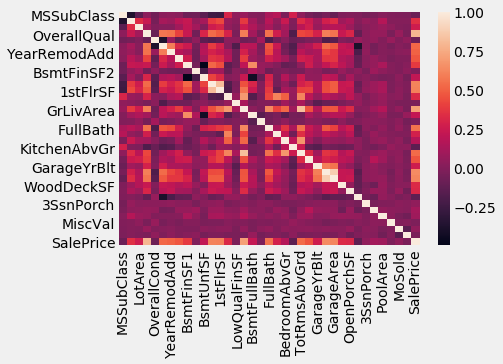

In [11]:
# sns.heatmap(train_clean.corr())

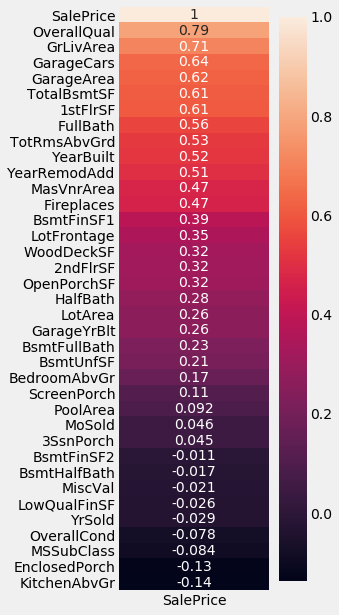

In [12]:
# corr_price = train_clean.corr()[['SalePrice']].sort_values('SalePrice',ascending=False)
# # Visualisation 0.25 de corrélatio
# #cols_corr = corr_price[corr_price >= 0.25].index
# #df_train_corr = df_train[cols_corr]
# plt.figure(figsize=(3,10))
# sns.heatmap(corr_price,annot=True)

On garde les variables quantitatives corrélées à plus de 25%

In [13]:
# corr_price = train_clean.corr()['SalePrice']

In [14]:
# cols_features = corr_price[corr_price > 0.25].index
# train_clean = train_clean[cols_features]

### Autre methode de selection

Prendre toutes les variables corréllés à plus de 0%.

Les faire tourner avec une méthode de selection de variable tel que le stepwise, mais en choisissant les variables sur le critère de L'AIC. c'est à dire en minimisant l'AIC. on choissira l'ensemble des variables qui minimise l'AIC. 
Après application de cette méthode on obtient les variables ci-dessous.

In [10]:
# X correspond au dataframe du train
# df_test correspond au dataframe du test

X = train_clean[["OverallQual","GrLivArea","BsmtFinSF1","GarageCars","MSSubClass","BedroomAbvGr","MasVnrArea","WoodDeckSF",
"LotArea","BsmtFullBath","FullBath","OverallCond","TotalBsmtSF","TotRmsAbvGrd","KitchenAbvGr","ScreenPorch",
"HalfBath","EnclosedPorch","LowQualFinSF",'CentralAir','Electrical','HeatingQC','Neighborhood','ExterQual']]

df_test = test_clean[["OverallQual","GrLivArea","BsmtFinSF1","GarageCars","MSSubClass","BedroomAbvGr","MasVnrArea","WoodDeckSF",
"LotArea","BsmtFullBath","FullBath","OverallCond","TotalBsmtSF","TotRmsAbvGrd","KitchenAbvGr","ScreenPorch",
"HalfBath","EnclosedPorch","LowQualFinSF",'CentralAir','Electrical','HeatingQC','Neighborhood','ExterQual']]

### Get dummies

In [11]:
# on garde dans une variable le shape des dataframes X et df_test pour pouvoir les resplit après
n_X = train.shape[0]
n_df_test = test.shape[0]

# On concatène ensuite les dataframes X et df_test pour faire le get_dummies sur l'ensemble 
df_concat = pd.concat((X, df_test)).reset_index(drop=True)

# le dummies sur le df_concat
df_with_dummies = pd.get_dummies(df_concat)

### Resplit du df_with_dummies en X et df_test

In [12]:
X = df_with_dummies[:n_X]
df_test = df_with_dummies[n_X:]

## Création de features

## Transformations de valeurs

## Gestion des outliers

## Modèle d'apprentissage
- Définir un seuil final pour le test_size
- On a temporairement retiré *GarageYrBlt* et *MasVnrArea* dû aux valeurs manquantes non traitées

### Normalisation de X et y
Par une échèlle logarithmique

In [31]:
# normalisation de X
X = np.log(X+1)

# Le target la variable à prédire
y = target
# normalisation de y
y = np.log(y+1)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

# Entrainement du model
model_house = linear_model.LinearRegression()
model_house.fit(X_train, y_train)

# prediction sur le test pour tester le model
y_pred = model_house.predict(X_test)

# Metrics
print('Mean Squared Error : {}\n'.format(mean_squared_error(y_test, y_pred)))
print('Root Mean Squared Error : {}\n'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('coefficient de determination : {}\n'.format(r2_score(y_test, y_pred)))

Mean Squared Error : 4.2604161848896075e+20

Root Mean Squared Error : 20640775627.11636

coefficient de determination : -2.5893218105206217e+21



## Prédiction sur le test

### Normalisation du df_test
Par une échèlle logarithmique

In [24]:
#test_clean = test_clean[cols_features.drop('SalePrice')]

In [15]:
df_test = np.log(df_test+1)

pred_test = model_house.predict(df_test)

### Dénormalisation de la prediction

Pour obtenir les valeurs à la bonne échèlle

In [18]:
pred_test = np.exp(pred_test)

### Soumission sur Kaggle

In [19]:
#pred_test = np.exp(pred_test)

pred = pd.DataFrame(test_id)

pred['SalePrice']=pred_test

In [21]:
#pred

In [23]:
pred.to_csv('house_prediction_kaggle', index=False, encoding='utf-8')

## Resultat Kaggle

In [27]:
#<img src="C:/Users/Administrateur/Pictures/Screenshots/Capture d’écran (1).png">

# Regression Lasso

Pour que la regression lassoCV soit optimal il est néccessaire que les données soient normalisée c'est à dire centrée et réduites

In [13]:
# LcvX correspond au dataframe du train
# Lcvdf_test correspond au dataframe du test

LcvX = df_with_dummies[:n_X]
Lcvdf_test = df_with_dummies[n_X:]

In [14]:
# on concatène les données du train et de le target afin de les normaliser en même temps
LcvX = pd.concat((LcvX, target), axis=1).reset_index(drop=True)

### Normalisation

In [15]:
sc_train = StandardScaler()

LcvX_norm = sc_train.fit_transform(LcvX)

C:\Users\Administrateur\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Administrateur\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Construction du model

In [16]:
model_house_lcv = LassoCV(normalize=False,fit_intercept=False,random_state=0,cv=5)

# lancement sur l'échantillon d'apprentissage
# -1 parceque le SalePrice se trouve à la fin
model_house_lcv.fit(LcvX_norm[:,:-1],LcvX_norm[:,-1])

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=False,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=0, selection='cyclic',
    tol=0.0001, verbose=False)

## Application du modèle sur le test

### Normalisation du test

In [17]:
sc_test = StandardScaler()
Lcvdf_test_norm =  sc_test.fit_transform(Lcvdf_test)

C:\Users\Administrateur\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Administrateur\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [18]:
# Prediction avec le modèle
pred_Lcv_norm = model_house_lcv.predict(Lcvdf_test_norm)

In [19]:
# dénormalisation de la prédiction, [-1] parce que y est en dernière position
pred_Lcv = pred_Lcv_norm*np.sqrt(sc_train.var_[-1]) + sc_train.mean_[-1]

## Soumission Kaggle

In [20]:
pred = pd.DataFrame(test_id)

pred['SalePrice']=pred_Lcv

pred.to_csv('first_house_prediction', index=False, encoding='utf-8')

In [21]:
pred

,Id,SalePrice
0,1461,123826.479181
1,1462,166865.724737
2,1463,172437.764134
3,1464,195976.127885
4,1465,242068.269002
5,1466,175414.468102
6,1467,199008.026558
7,1468,161973.677535
8,1469,191144.279078
9,1470,119240.055771
